# Métodos em espaços de ação contínuos (DDPG)

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="platoon.png" width="300">

Objetivo: usar o algoritmo do *Deep Deterministic Policy Gradient* (DDPG) para encontrar uma política $\pi(s,\boldsymbol{\theta})$ que controle um comboio de (dois) veículos.

## Características do ambiente:

O ambiente é composto por dois veículos que viajam longitudinalmente em uma estrada, um líder e um seguidor. O objetivo principal é calcular os comandos de aceleração $u_1(t)$ do veículo seguidor em função do erro de sua posição $e_p(t)$, velocidade $e_v(t)$ e aceleração $e_a(t)$ em relação ao líder.

### Espaço de observações

Erros de posição, velocidade e aceleração do seguidor em relação ao líder:

$
\begin{bmatrix}
    e_p(t)\\
    e_v(t)\\
    e_a(t)
\end{bmatrix}
=
\begin{bmatrix}
    p_1(t) - p_0(t) - \delta_{0,1}\\
    v_1(t) - v_0(t)\\
    a_1(t) - a_0(t)
\end{bmatrix}$


### Espaço de ações

Comando de aceleração $u(t)$ para o veículo seguidor, limitado a $-3m/s^2 \leq u(t) \leq 3m/s^2$.

### Função de reforço

O objetivo da função de reforço é reduzir os erros de posição, velocidade e aceleração, aplicando um comando de aceleração que esforço o acelerador o mínimo possível. Formalmente,

$r(t) = \dfrac{1}{e^k}$, onde $k = 0.3 e_p(t)^2 + 0.3 e_v(t)^2 + 0.3 e_a(t)^2 + 0.2 u_1(t)^2.$


Importando as bibliotecas.

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14,6)
from IPython.display import clear_output
from collections import deque, namedtuple
import seaborn as sns
sns.set()
import random
import class_env as ce

Cria uma classe (```RunningAverage()```) apenas para calcular a média móvel do sinal de reforço.

In [2]:
class RunningAverage(object):
    def __init__(self, N):
        self.buffer = deque(maxlen=N)

    def push(self, val):  
        self.buffer.append(val)

    def get(self):
        return np.mean(self.buffer)

Gerenciando o replay buffer. O buffer tem tamanho fixo e armazena tuplas de experiências com o ambiente.

In [3]:
class ReplayBuffer:
    ##########################################
    def __init__(self, parameters, buffer_size=int(1e5)):
        
        self.batch_size = parameters['batch_size']
        self.device = parameters['device']
        
        self.D = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["S", "A", "R", "Sl", "done"])
    
    ##########################################
    # Adiciona uma nova experiencia ao buffer
    def push(self, S, A, R, Sl, done):
        e = self.experience(S, A, R, Sl, done)
        self.D.append(e)
    
    ##########################################
    # Escolhe aleatoriamente um mini-lote das experiencias
    def sample(self):
        Dj = random.sample(self.D, k=np.min([len(self.D), self.batch_size]))
    
        states = torch.from_numpy(np.vstack([e.S for e in Dj if e is not None])).float()#.to(self.device)
        actions = torch.from_numpy(np.vstack([e.A for e in Dj if e is not None])).long()#.to(self.device)
        rewards = torch.from_numpy(np.vstack([e.R for e in Dj if e is not None])).float()#.to(self.device)
        next_states = torch.from_numpy(np.vstack([e.Sl for e in Dj if e is not None])).float()#.to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in Dj if e is not None]).astype(np.uint8)).float()#.to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    
    ##########################################
    def __len__(self):
        return len(self.D)

In [4]:
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, 1.0*t / self.decay_period)
        #return np.clip(action + ou_state, self.low, self.high) # *** esse clip estava atrapalhando o calculo da acao de controle ***
        return action + ou_state

O *ator* é representado pela função diferenciável $\pi(a|s, \boldsymbol{\theta})$ que fornece a probabilidade de cada ação $a$ ser escolhida, dado um estado $s$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, ```action_size``` saídas e duas camadas escondidas de tamanho ```hidden_size = 256```.

In [5]:
class Actor(nn.Module):
    ###########################################
    def __init__(self, input_size, output_size, hidden_size=256):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    ###########################################
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        return torch.tanh(self.linear3(x))

O *crítico* é representado pela função diferenciável $\hat{q}(s, a, \boldsymbol{w})$ que fornece o valor de um dado $s$ e uma dada ação $a$. A arquitetura da Rede Neural Artificial (Perceptron) tem ```state_size``` entradas, uma saída e duas camadas escondidas de tamanho ```hidden_size = 256```.

In [6]:
class Critic(nn.Module):
    ###########################################
    def __init__(self, input_size, output_size, hidden_size=256):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    ###########################################
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [7]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """
    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

Criando a classe do algortimo do DDPG.

In [8]:
class DDPG:
    ###########################################
    def __init__(self, parameters):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.alpha = parameters['alpha']
        self.beta = parameters['beta']
        self.tau = parameters['tau']
        self.device = parameters['device']
        self.batch_size = parameters['batch_size']

        # cria ambiente
        self.env = ce.PlatoonEnv()
        self.env = NormalizedEnv(self.env)

        # create noise
        sigma = 0.15
        self.noise = OUNoise(self.env.action_space, max_sigma=sigma, theta = 0.1, min_sigma=0.5*sigma, decay_period = parameters['episodes'])
        
        # Params
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.shape[0]

        # Networks
        self.actor = Actor(self.num_states, self.num_actions)#.to(self.device)
        self.actor_target = Actor(self.num_states, self.num_actions)#.to(self.device)
        
        self.critic = Critic(self.num_states + self.num_actions, self.num_actions)#.to(self.device)
        self.critic_target = Critic(self.num_states + self.num_actions, self.num_actions)#.to(self.device)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        # Buffer de armazenamento de experiencias
        self.D = ReplayBuffer(parameters)
        
        # Training
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=self.beta)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.alpha)

    ###########################################
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action

    ###########################################
    def update(self):
        
        # Seleciona um mini-lote Dj de D e apŕende
        states, actions, rewards, next_states, _ = self.D.sample()

        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_criterion(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()

        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

Faz a atualização das redes-alvo:

$\boldsymbol{w}' \gets \tau \boldsymbol{w} + (1-\tau) \boldsymbol{w}'$

$\boldsymbol{\theta}' \gets \tau \boldsymbol{\theta} + (1-\tau) \boldsymbol{\theta}'$

In [9]:
class DDPG(DDPG):
    ###########################################
    def updateTargets(self):

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

Executando um episódio.

In [10]:
class DDPG(DDPG):
    ##########################################
    def runEpisode(self):
        
        # novo episodio
        self.episode += 1
        
        rewards = []
        
        self.noise.reset()

        # reseta o ambiente
        S = self.env.reset()
        
        # Gerando a experiencia a partir da politica
        for step in range(self.max_iter):
            
            A = self.get_action(S)
            A = self.noise.get_action(A, step)
            Sl, R, done, _ = self.env.step(A)
            
            rewards.append(R)
            
            # Armazena a experiencia (S,A,R,Sl) no buffer D
            self.D.push(S, A, R, Sl, done)
            self.update()
            
            # atualiza as redes-alvo
            self.updateTargets()

            S = Sl

            if done: break
        
        return np.sum(np.array(rewards))

Programa principal:
- episodes: número de episódios
- max_iter: máximo de iterações até o fim do episódio
- gamma: fator de desconto
- alpha: $\alpha$
- beta: $\beta$
- tau: $\tau$ (atualização das redes alvo)
- device: usa *cpu* ou *gpu*

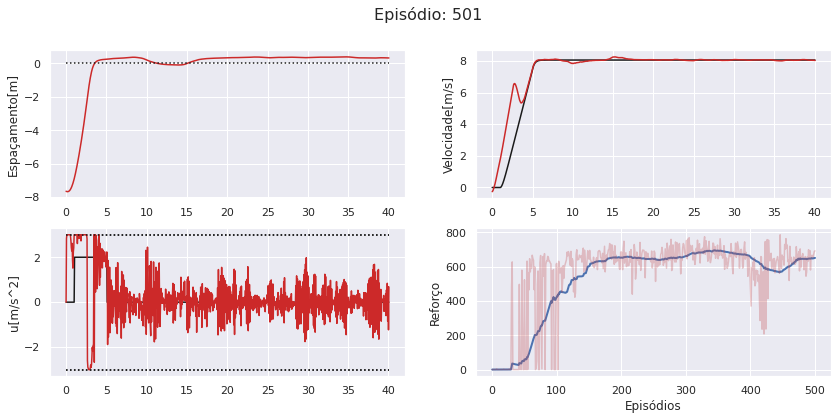

In [11]:
if __name__ == '__main__':
    
    plt.ion()

    # cria objeto para calculo da média movel do reward
    avg_calc = RunningAverage(50)
    
    # parametros
    parameters = {'episodes'  : 500,
                  'max_iter'  : 3000,
                  'gamma'     : 0.99,
                  'alpha'     : 0.002,
                  'beta'      : 0.001,
                  'tau'       : 0.001, #5.0e-3
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  'batch_size': 64,
                 }
    
    # historico dos reforços
    rewards = []
    avg_rewards = []
    
    ddpg = DDPG(parameters)
    
    while ddpg.episode <= parameters['episodes']:
        
        # roda um episodio
        total_reward = ddpg.runEpisode()

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_calc.push(total_reward)
        avg_rewards.append(avg_calc.get())

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.gcf().suptitle('Episódio: %d' % ddpg.episode, fontsize=16)

        # posicao
        plt.subplot(221)
        ddpg.env.plotEsp()
        # velocidade
        plt.subplot(222)
        ddpg.env.plotVel()
        # aceleracao
        plt.subplot(223)
        ddpg.env.plotU()
        #
        plt.subplot(224)
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        #plt.title('Reforço por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Reforço')

        plt.show()
        plt.pause(.1)

    plt.ioff()